<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step4_sparktorch_sgd_M250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download preprocessed dataset
# !wget -qO ratings_M50.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/EWqG6YIAGfpLihYVvtpMeRQB1ngfhPZPydHCoUL87QR3yA?download=1
# !wget -qO ratings_M1000.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/ESYy4ukVKs9DkY6-YVBh-0kBr5uQE29dC1Tq0PRi_tJJhg?download=1
# !wget -qO ratings_M500.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/ESs56OiZeCRNu3gxxbzvOe0Ba2NS91yE3YQLEVctNGx78w?download=1
!wget -qO ratings_M250.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/EcVCh5WF9qJAjSSTKs1i7FIBWoAs0814U2EA3gDgJrJGdw?download=1

In [2]:
!pip -q install sparktorch pyspark

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 11.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from sparktorch import serialize_torch_obj, SparkTorch
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, floor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline
ps.options.display.max_rows = 5

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [12]:
# read dataset into dataframe

spark = SparkSession.builder.appName("MyApp").master('local').getOrCreate()
df = ps.read_csv('ratings_M250.csv')
df['label'] = df.rating / 6
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


num_user: 20068 num_movie: 250


,user,movie,rating,label
0,0,0,3,0.500000
1,1,0,4,0.666667
2,2,0,3,0.500000
3,3,0,3,0.500000
4,4,0,5,0.833333


In [13]:
# split data into train and test sets

max_test_split = 0.2        # for a smaller dataset, we take 20% for test
max_test_num = 100_000      # for a larger dataset, we take 100_000 only
num_fold = 1 / min(max_test_num/len(df), max_test_split)

df = df.to_spark().withColumn('fold', floor(rand()*num_fold))
df_train = df.filter(col('fold') != 0)
df_test  = df.filter(col('fold') == 0)

va = VectorAssembler(inputCols=['user', 'movie'], outputCol='features')
df_train = va.transform(df_train)
df_test  = va.transform(df_test)

print(f'df_train: {df_train.count():,} rows')
df_train.show(5)
print(f'df_test: {df_test.count():,} rows')
df_test.show(5)

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


df_train: 229,490 rows
+----+-----+------+------------------+----+---------+
|user|movie|rating|             label|fold| features|
+----+-----+------+------------------+----+---------+
|   0|    0|     3|               0.5|   1|(2,[],[])|
|   1|    0|     4|0.6666666666666666|   4|[1.0,0.0]|
|   2|    0|     3|               0.5|   4|[2.0,0.0]|
|   3|    0|     3|               0.5|   2|[3.0,0.0]|
|   4|    0|     5|0.8333333333333334|   1|[4.0,0.0]|
+----+-----+------+------------------+----+---------+
only showing top 5 rows

df_test: 57,273 rows
+----+-----+------+------------------+----+----------+
|user|movie|rating|             label|fold|  features|
+----+-----+------+------------------+----+----------+
|  22|    0|     3|               0.5|   0|[22.0,0.0]|
|  23|    0|     4|0.6666666666666666|   0|[23.0,0.0]|
|  27|    0|     5|0.8333333333333334|   0|[27.0,0.0]|
|  28|    0|     4|0.6666666666666666|   0|[28.0,0.0]|
|  29|    0|     2|0.3333333333333333|   0|[29.0,0.0]|
+----

In [14]:
# build the matrix-multiplication-based model

class MatrixMultiplicationModel(nn.Module):
    def __init__(self, num_user, num_movie, emb_dim):
        super().__init__()
        self.U = nn.Embedding(num_user, emb_dim)    # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(num_movie, emb_dim)   # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, um_idxs):
        u_idx, m_idx = um_idxs[:,0].int(), um_idxs[:,1].int()
        U = self.U(u_idx)                           # retrieve user embeddings by user indexes
        V = self.V(m_idx)                           # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)             # predicted ratings are their dot products
        # output = torch.sigmoid(dot_products)      # map to [0,1]
        output = dot_products
        return output

In [15]:
# set hyperparameters
D = 10              # embedding dimension
lr = 1e-3           # learning rate
batch_size = 256
max_loop = 200_000
report_per_nloop = 100
patience = 10       # early stop if not improving in this num of evaluations
optimizer=torch.optim.Adam

# initialize model and ...
py_model = MatrixMultiplicationModel(num_user =N,
                                     num_movie=M,
                                     emb_dim  =D)
criterion = nn.MSELoss()
Optimizer = optim.Adam

# Build the pytorch object
torch_obj = serialize_torch_obj(
    model=py_model,
    criterion=criterion,
    optimizer=Optimizer,
    lr=lr,
)

In [16]:
# prepare test data
test_x = torch.IntTensor(df_test.select('user', 'movie').collect())
test_y = torch.FloatTensor(df_test.select('label').collect()).squeeze()

In [17]:
# train

min_test_loss = None
recs = []
for i in range(max_loop):
    
    # fit for {report_per_nloop} loops
    torch_obj = serialize_torch_obj(
        model=py_model,
        criterion=criterion,
        optimizer=Optimizer,
        lr=lr,
    )
    spark_model = SparkTorch(
        inputCol='features',
        labelCol='label',
        predictionCol='prediction',
        torchObj=torch_obj,
        iters=report_per_nloop,
        miniBatch=batch_size,
        verbose=1,
    ).fit(df_train)

    # calculate test loss
    py_model = spark_model.getPytorchModel()
    with torch.no_grad():
        test_y_hat = py_model(test_x)
    test_loss = criterion(test_y_hat, test_y).item()

    rec = {
        'batch'     : i*report_per_nloop,
        'test_loss' : test_loss,
    }
    recs.append(rec)
    print(rec)

    # check for early stopping
    if min_test_loss is None or test_loss < min_test_loss:
        min_test_loss = test_loss
        not_improving_count = 0
    else:
        not_improving_count += 1
        if not_improving_count >= patience:
            break

{'batch': 0, 'test_loss': 9.072376251220703}
{'batch': 100, 'test_loss': 8.353323936462402}
{'batch': 200, 'test_loss': 7.678772926330566}
{'batch': 300, 'test_loss': 7.052095890045166}
{'batch': 400, 'test_loss': 6.475436210632324}
{'batch': 500, 'test_loss': 5.943121433258057}
{'batch': 600, 'test_loss': 5.4454345703125}
{'batch': 700, 'test_loss': 4.981658935546875}
{'batch': 800, 'test_loss': 4.557436466217041}
{'batch': 900, 'test_loss': 4.1642255783081055}
{'batch': 1000, 'test_loss': 3.8124289512634277}
{'batch': 1100, 'test_loss': 3.4913580417633057}
{'batch': 1200, 'test_loss': 3.2032878398895264}
{'batch': 1300, 'test_loss': 2.943425178527832}
{'batch': 1400, 'test_loss': 2.707773208618164}
{'batch': 1500, 'test_loss': 2.4956533908843994}
{'batch': 1600, 'test_loss': 2.3069252967834473}
{'batch': 1700, 'test_loss': 2.137755870819092}
{'batch': 1800, 'test_loss': 1.9857661724090576}
{'batch': 1900, 'test_loss': 1.8526901006698608}
{'batch': 2000, 'test_loss': 1.733115077018737

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


{'batch': 2700, 'test_loss': 1.1788808107376099}
{'batch': 2800, 'test_loss': 1.1293978691101074}
{'batch': 2900, 'test_loss': 1.0859308242797852}
{'batch': 3000, 'test_loss': 1.0458383560180664}
{'batch': 3100, 'test_loss': 1.0089970827102661}
{'batch': 3200, 'test_loss': 0.9755668044090271}
{'batch': 3300, 'test_loss': 0.944000244140625}
{'batch': 3400, 'test_loss': 0.914379358291626}
{'batch': 3500, 'test_loss': 0.8871583938598633}
{'batch': 3600, 'test_loss': 0.8616001605987549}
{'batch': 3700, 'test_loss': 0.8366503715515137}
{'batch': 3800, 'test_loss': 0.8140779137611389}
{'batch': 3900, 'test_loss': 0.7927492260932922}
{'batch': 4000, 'test_loss': 0.772687554359436}
{'batch': 4100, 'test_loss': 0.7538703083992004}
{'batch': 4200, 'test_loss': 0.7355554699897766}
{'batch': 4300, 'test_loss': 0.7182838320732117}
{'batch': 4400, 'test_loss': 0.7010724544525146}
{'batch': 4500, 'test_loss': 0.6853510737419128}
{'batch': 4600, 'test_loss': 0.6703556776046753}
{'batch': 4700, 'test_l

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


{'batch': 10700, 'test_loss': 0.18968655169010162}
{'batch': 10800, 'test_loss': 0.18573208153247833}
{'batch': 10900, 'test_loss': 0.1820976585149765}
{'batch': 11000, 'test_loss': 0.17841693758964539}
{'batch': 11100, 'test_loss': 0.17505024373531342}
{'batch': 11200, 'test_loss': 0.17122040688991547}
{'batch': 11300, 'test_loss': 0.1680048257112503}
{'batch': 11400, 'test_loss': 0.16457590460777283}
{'batch': 11500, 'test_loss': 0.16142426431179047}
{'batch': 11600, 'test_loss': 0.1582673043012619}
{'batch': 11700, 'test_loss': 0.15532438457012177}
{'batch': 11800, 'test_loss': 0.1523260474205017}
{'batch': 11900, 'test_loss': 0.14930635690689087}
{'batch': 12000, 'test_loss': 0.14649628102779388}
{'batch': 12100, 'test_loss': 0.14374536275863647}
{'batch': 12200, 'test_loss': 0.14089998602867126}
{'batch': 12300, 'test_loss': 0.13820454478263855}
{'batch': 12400, 'test_loss': 0.13555283844470978}
{'batch': 12500, 'test_loss': 0.13311077654361725}
{'batch': 12600, 'test_loss': 0.130

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

<Axes: xlabel='batch'>

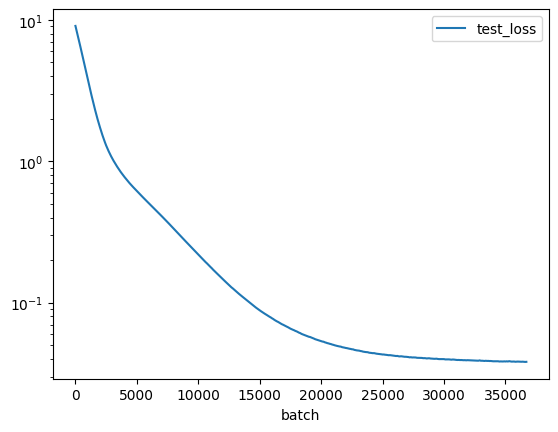

In [18]:
# training curves
pd.DataFrame(recs).set_index('batch')[['test_loss']].plot(logy=True)

In [19]:
# resulted U and V
U = py_model.U.weight
V = py_model.V.weight

print('first few rows of,')
print('U:', U[:3])
print('V:', V[:3])

first few rows of,
U: tensor([[-0.0754, -1.6003,  1.0082,  1.0944, -0.5273, -1.1441,  0.7218,  1.2723,
          0.5193,  2.1104],
        [ 1.8255,  0.4926,  0.6160,  0.9614,  0.0073, -1.5961, -0.3806, -1.3007,
          1.5555, -0.1252],
        [ 1.7615,  0.3630,  0.1206,  1.0465, -0.7564, -0.4523,  0.1570,  0.1554,
          0.0175,  0.3860]], grad_fn=<SliceBackward0>)
V: tensor([[ 0.1643,  0.1765,  0.1681,  0.1886,  0.1792, -0.1961, -0.1922,  0.1669,
         -0.1316,  0.1751],
        [-0.3730,  0.0916,  0.5676,  0.3057, -0.3582,  0.4849, -0.7653,  0.3354,
          0.2336,  0.8310],
        [ 0.1651,  0.1831,  0.1673,  0.1887,  0.1755, -0.1860, -0.1864,  0.1675,
         -0.1430,  0.1713]], grad_fn=<SliceBackward0>)


In [20]:
# prediction results

with torch.no_grad():
    test_y_hat = py_model(test_x)

df_res = (
    df_test.toPandas()
    .assign(target_pred    =test_y_hat,
            rating_pred    =lambda x: (x.target_pred*6).clip(1,5),  # clipped between 1 and 5
            rating_residual=lambda x: x.rating - x.rating_pred)
)

df_res.sample(10)

,user,movie,rating,label,fold,features,target_pred,rating_pred,rating_residual
32121,412,165,4,0.666667,0,"[412.0, 165.0]",0.571787,3.430721,0.569279
52906,16278,224,2,0.333333,0,"[16278.0, 224.0]",0.583769,3.502617,-1.502617
4845,14810,27,5,0.833333,0,"[14810.0, 27.0]",0.574955,3.449731,1.550269
8728,162,38,2,0.333333,0,"[162.0, 38.0]",0.568479,3.410874,-1.410874
10175,14598,45,4,0.666667,0,"[14598.0, 45.0]",0.570824,3.424945,0.575055
44677,2848,196,3,0.500000,0,"[2848.0, 196.0]",0.577251,3.463507,-0.463507
27777,14597,142,3,0.500000,0,"[14597.0, 142.0]",0.568683,3.412098,-0.412098
15683,6266,77,4,0.666667,0,"[6266.0, 77.0]",0.572603,3.435616,0.564384
35900,10551,174,5,0.833333,0,"[10551.0, 174.0]",0.565110,3.390658,1.609342
39921,2862,188,3,0.500000,0,"[2862.0, 188.0]",0.582028,3.492171,-0.492171


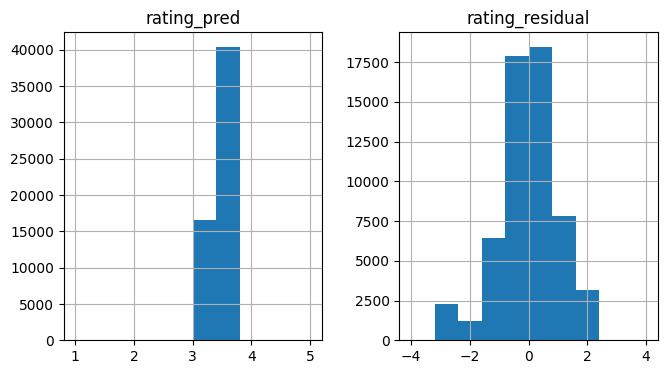

In [27]:
# distribution of residuals
df_res[['rating_pred', 'rating_residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()